In [1]:
!pip install -q qiskit
!pip install -q qiskit_machine_learning
!pip install -q pylatexenc
!pip install -q qiskit-machine-learning[sparse]

# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
project_dir = "/content/drive/MyDrive/Ananth_MS-thesis_2022-23/Code-Notebooks/generating hard distributions/"
sys.path.append(project_dir)

import qiskit
from qiskit_machine_learning.neural_networks import CircuitQNN


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [4]:
from main import create_qnn, main
from Auxillary_functions import (
    MeasurementDataset,
    get_decodedstates,
    get_dict_from_array,
    decorate_plot
)
from Model_learndist import QVAE_qcompile
from Training import QStatecompilation

In [5]:
# Load datafile

filename = os.path.join(project_dir, "nqubits_4_x04h02y24.npy")
datafile = np.load(filename)
n_samples = datafile.shape[0]
results = get_dict_from_array(datafile)
print("No of samples", n_samples)

No of samples 8192


In [6]:
datafile[:5]

array([[0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 0.]])

In [7]:
# Setup training and testing datasets

want_datasetsize= 0.2  # can change to 0.2
train_size = 0.85
training_dataset = MeasurementDataset(datafile[: int(want_datasetsize*train_size * n_samples)])
valid_dataset = MeasurementDataset(datafile[int(want_datasetsize*train_size * n_samples) : int(want_datasetsize * n_samples)])

train_dataloader = DataLoader(
    training_dataset, batch_size=1, shuffle=True, num_workers=1
)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=1)

dataloaders = [train_dataloader, valid_dataloader]
dataloader_info = "Size of training set: %d | Size of validation set: %d"% (len(train_dataloader), len(valid_dataloader))
print(dataloader_info)

Size of training set: 1392 | Size of validation set: 246


In [8]:
# Set simulation parameters

patience = 5
encoder_lr = 0.003; decoder_lr = 0.01
lr = [encoder_lr, decoder_lr]
minibatchsize=32
beta = 2.
latentsize=2
num_epochs = 30
root_dir = os.path.join(project_dir, "log-files/branch_outputlogdict")
true_result_keys = get_dict_from_array(datafile).keys()
print(true_result_keys)

dict_keys(['0011', '0001', '0000', '0010'])


In [9]:
root_dir

'/content/drive/MyDrive/Ananth_MS-thesis_2022-23/Code-Notebooks/generating hard distributions/log-files/branch_outputlogdict'

In [10]:
params = {'minibatchsize': minibatchsize,
       'beta':beta, 'latentsize':latentsize,
       'num_epochs':num_epochs, 'root_dir':root_dir }

In [11]:
trained_model = main(patience, lr, dataloaders, list(true_result_keys), params)

No of trainable parameters: 
 (Model:143) | (Encoder:103) | (Decoder:8) 
 Total number of epochs: 30 | Total number of batches: 43
(1|30 , 1|43) Total loss: 0.08287 | Likelihood loss: 0.08049 | KL loss : 0.00238 
(1|30 , 2|43) Total loss: 0.05238 | Likelihood loss: 0.05138 | KL loss : 0.00100 
(1|30 , 3|43) Total loss: 0.06585 | Likelihood loss: 0.06429 | KL loss : 0.00156 
(1|30 , 4|43) Total loss: 0.11830 | Likelihood loss: 0.11732 | KL loss : 0.00098 
(1|30 , 5|43) Total loss: 0.04767 | Likelihood loss: 0.04616 | KL loss : 0.00151 
(1|30 , 6|43) Total loss: 0.04114 | Likelihood loss: 0.03967 | KL loss : 0.00147 
(1|30 , 7|43) Total loss: 0.13092 | Likelihood loss: 0.12999 | KL loss : 0.00093 
(1|30 , 8|43) Total loss: 0.16155 | Likelihood loss: 0.16063 | KL loss : 0.00092 
(1|30 , 9|43) Total loss: 0.11341 | Likelihood loss: 0.11250 | KL loss : 0.00091 
(1|30 , 10|43) Total loss: 0.04872 | Likelihood loss: 0.04739 | KL loss : 0.00133 
(1|30 , 11|43) Total loss: 0.10039 | Likelihood 

# Plot results

In [29]:
# Choose the directory that contains the log files
available_files = os.listdir(root_dir)
available_files

['qvae_qstatecompilation_lr003_01_2022_09_20-05_32_18_AM',
 'qvae_qstatecompilation_lr003_01_2022_09_20-08_19_15_AM']

In [30]:
#current_dir = 'qvae_qstatecompilation_lr003_01_2022_09_20-08_19_15_AM'
current_dir = available_files[1]
results = ['_training_data.txt','_valid_data.txt']
loss_files = [os.path.join(current_dir,"%s%s"%(current_dir, fname)) for fname in results]
loss_filepath = [os.path.join(root_dir, fname) for fname in loss_files]

In [130]:
def get_validlosses(filepath:str):
    df = pd.read_csv(filepath, header=None, skiprows=3)
    df['valid_loss'] = df[0].apply(lambda x: x.split(' ')[1].split('(')[1][:-1]).astype(float)
    df.drop(0, axis=1,inplace=True)
    return df

def get_trainingloss(filepath:str):
    training_losses = pd.read_csv(filepath, skiprows=3, header=None)
    training_losses['combined_loss'] = training_losses[0].apply(lambda x: x.split(" ")[1][1:]).astype(float)
    training_losses['kl_loss'] = training_losses[2].apply(lambda x: x[:-2]).astype(float)
    training_losses['mse_loss'] = training_losses[1].astype(float)
    training_losses.drop([0,1,2], axis=1, inplace=True)
    return training_losses

def get_rightsample_masses(current_dir:str, root_dir:str):
    right_masses = "_mass_rightsamples.txt"
    rightmass_file = os.path.join(current_dir, "%s%s"%(current_dir, right_masses))
    rightmass_filepath = os.path.join(root_dir, rightmass_file)
    df = pd.read_csv(rightmass_filepath, skiprows=3, header=None)
    df['mass'] = df[0].apply(lambda x : x.split(' ')[1]).astype(float)
    df.drop(0, axis=1, inplace=True)
    return df

def get_output_dict(current_dir:str, root_dir:str):
    out_distfile_ext = "_output_dist.txt"
    out_dist_filepath = os.path.join(current_dir, "%s%s"%(current_dir, out_distfile_ext))
    out_dist_filepath = os.path.join(root_dir, out_dist_filepath)

    with open(out_dist_filepath, 'r') as rf:
        dist_file = rf.readlines()[3:]
    output_dictlist_epochwise = []
    for line in dist_file:
        given_dist = line.split("{")[1][:-3]
        dict_like = given_dist.split(', ')
        output_dict_epochwise = {}
        for j in dict_like:
            key = j.split('\'')[1]
            val = j.split(": ")[1]
            output_dict_epochwise[key]=val
        output_dictlist_epochwise.append(output_dict_epochwise)
    return output_dictlist_epochwise

def get_bhattacoef(distribtuion:dict, true_dist:dict) -> float:
    """Source:https://en.wikipedia.org/wiki/Fidelity_of_quantum_states"""
    true_array = np.array(list(true_dist.values()))
    given_array = np.array(list(distribtuion.values()), dtype=float)

    #return -np.log(np.sum(np.sqrt(true_array * given_array)))
    return np.sum(np.sqrt(true_array * given_array))

In [32]:
import pandas as pd
import seaborn as sns

train_loss = get_trainingloss(loss_filepath[0])
valid_losses = get_validlosses(loss_filepath[1])
rightsample_masses = get_rightsample_masses(current_dir, root_dir)

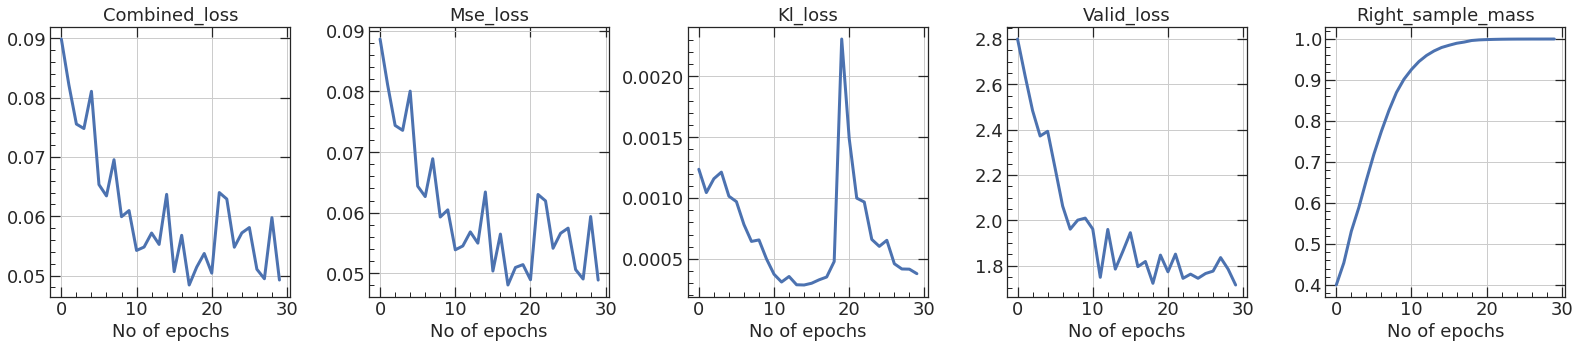

In [35]:
fig, axes = plt.subplots(1,5, figsize=(22,5))

titles = "Combined_loss Mse_loss  Kl_loss Valid_loss Right_sample_mass".split()

axes[0].plot(train_loss['combined_loss'].values, lw=3)
axes[1].plot(train_loss['mse_loss'].values, lw=3)
axes[2].plot(train_loss['kl_loss'].values, lw=3)
axes[3].plot(valid_losses['valid_loss'].values, lw=3)
axes[4].plot(rightsample_masses['mass'].values, lw=3)

for idx, ax in enumerate(axes):
    ax.set_title(titles[idx], fontsize=18)
    ax.set_xlabel("No of epochs", fontsize=18)
    decorate_plot(ax)


plt.tight_layout()
plt.savefig("%s/training_results.png"%(os.path.join(root_dir, current_dir)),
            dpi=300,bbox_inches='tight')

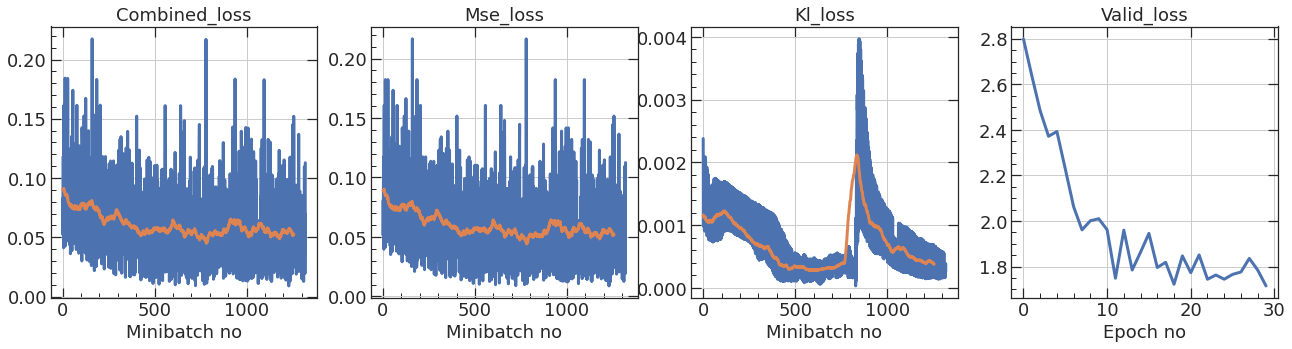

In [52]:
fig, ax = plt.subplots(1,4, figsize=(22,5))

for idx, (key, value) in enumerate(trained_model[1].logdict.items()):
    ax[idx].plot(value, lw=3)
    ax[idx].set_title(titles[idx], fontsize=18)
    decorate_plot(ax[idx])
    ax[idx].set_xlabel("Epoch no", fontsize=18)
    if idx <3:
        ax[idx].plot(np.convolve(value, np.ones(64)/64, mode='valid'), lw=3)
        ax[idx].set_xlabel("Minibatch no", fontsize=18)



In [36]:
from Auxillary_functions import get_decoder_dist, normalize

all_bitstrings = ["{0:04b}".format(i) for i in range(pow(2,4))]
out_dist = get_decoder_dist(trained_model[0], all_bitstrings, 200)

# Original results
orig_results = get_dict_from_array(datafile)
results_norm = normalize(orig_results)
results_norm_16 = {}
for state1 in all_bitstrings:
    if state1 in results_norm.keys():
        results_norm_16[state1] = results_norm[state1]
    else:
        results_norm_16[state1] = 0

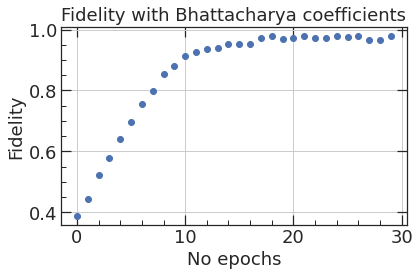

In [136]:
# Analyse distributions

output_dictlist_epochwise = get_output_dict(current_dir, root_dir)

bhatta_coefs = np.array([get_bhattacoef(dist, results_norm_16) for dist in output_dictlist_epochwise])

fig, ax = plt.subplots()
decorate_plot(ax)
ax.plot(bhatta_coefs**2, marker='o', ls=" ")
ax.set_xlabel("No epochs", fontsize=18)
ax.set_ylabel("Fidelity", fontsize=18)
ax.set_title("Fidelity with Bhattacharya coefficients", fontsize=18)
plt.tight_layout()
plt.show()

In [41]:
bhatta = -np.log(np.sum(np.sqrt(np.array(list(results_norm_16.values())) * np.array(list(out_dist.values())))))

print("Bhattacharya distance between learnt and true distributions: %.3e"%bhatta)

Bhattacharya distance between learnt and true distributions: 7.106e-03


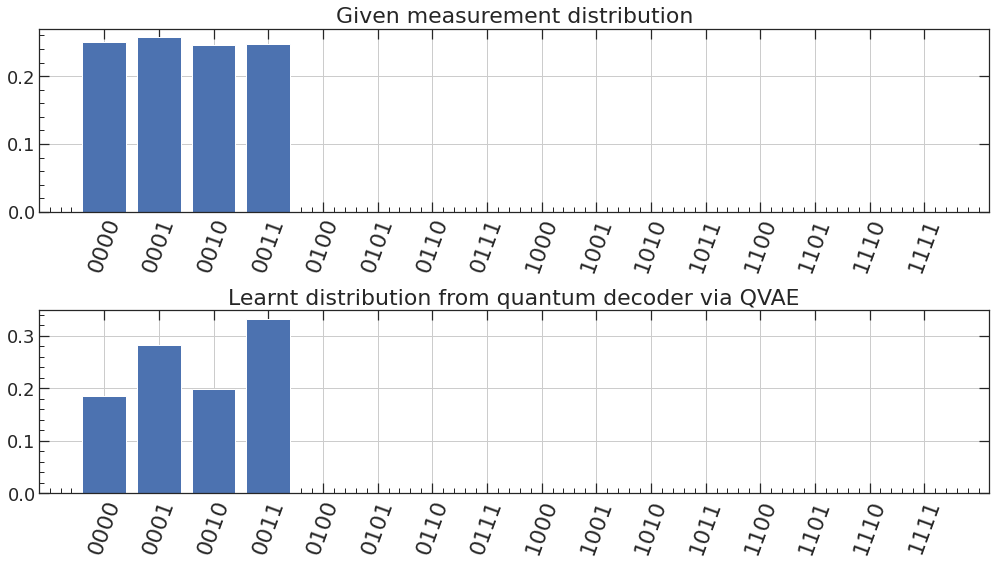

In [38]:
fig, axes = plt.subplots(2,1,figsize=(14,8))

for ax in axes:
    decorate_plot(ax)
    ax.set_xticks(np.arange(16))
    ax.set_xticklabels(out_dist.keys(), rotation=70, fontsize=22)

axes[0].set_title("Given measurement distribution", fontsize=22)
axes[0].bar(np.arange(16),results_norm_16.values())

axes[1].bar(np.arange(16), out_dist.values())
axes[1].set_title("Learnt distribution from quantum decoder via QVAE", fontsize=22)


plt.tight_layout()
plt.savefig("%s/distribution_results.pdf"%(os.path.join(root_dir, current_dir)),
            dpi=300,bbox_inches='tight')